# Car Fuel Emissions Dataset Dashboard

> This dashboard helps you explore the $CO_2$ emissions of different car models and their fuel consumption.

<b>[Data](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64) Updated as of June 15, 2023</b>

In [6]:
import ipywidgets as widgets
from ipywidgets import interact
from menu import init_widgets, style, setup_menu
from dashboard import (
    Seaborn_Barplot,
    Boxplot_ggplot,
    Seaborn_Scatter,
    Histogram_ggplot,
    Seaborn_Boxplot,
)
from IPython.display import display
import pandas as pd
import numpy as np

In [2]:
# flake8: noqa
def select_table(vehicle_type, year, vehicle_class, make, co2):
    query = f"""SELECT model_year, 
                make_, 
                model,
                vehicleclass_, 
                co2_rating, 
                co2emissions_g_km,
                mapped_fuel_type, 
                vehicle_type,
                fuelconsumption_city_l_100km,
                fuelconsumption_hwy_l_100km,
                consumption_combinedle_100km	
            FROM all_vehicles 
            WHERE model_year = {year}
            AND vehicleclass_ IN {vehicle_class}
            AND vehicle_type = '{vehicle_type}'
            AND make_ = '{make}'
            AND co2_rating >= {co2}
            """

    print("Performing query")
    # Use JupySQL magic %sql to execute the query
    result = %sql {{query}}

    # Convert the result to a Pandas DataFrame
    df = result.DataFrame()

    display(df)

In [3]:
%load_ext sql

%sql duckdb:///../data/database/car_data.duckdb

%config SqlMagic.displaycon = False

In [7]:
years = %sql select DISTINCT(model_year) from all_vehicles
years = [model_year[0] for model_year in years]

makes = %sql select DISTINCT(make_) from all_vehicles
makes = [m[0] for m in makes]

classes = %sql select DISTINCT(vehicleclass_) from all_vehicles
classes = [c[0] for c in classes]

co2 = %sql select DISTINCT(co2_rating) from all_vehicles
co2 = [c[0] for c in co2]

vehicle_type = %sql select DISTINCT(vehicle_type) from all_vehicles
vehicle_type = [v[0] for v in vehicle_type]

## Interactive Table

> Multiple values for Vehicle Class can be selected with shift and/or ctrl (or command) pressed and mouse clicks or arrow keys.

In [8]:
(
    widget_vehicle_type,
    widget_year,
    widget_make,
    widget_vehicle_class,
    widget_co2,
) = init_widgets(years, makes, classes, vehicle_type, style)

tab = setup_menu(
    widget_vehicle_type, widget_year, widget_vehicle_class, widget_make, widget_co2
)  # noqa E501

output = widgets.interactive_output(
    select_table,  # noqa f821
    {
        "vehicle_type": widget_vehicle_type,
        "year": widget_year,
        "vehicle_class": widget_vehicle_class,
        "make": widget_make,
        "co2": widget_co2,
    },
)

display(tab, output)

Output()

## Plots

This dashboard contains 5 plots, created using the `ggplot` API, `seaborn`, and `ipywidgets`:

1. Bar Plot of Car Manufacturing Trends
2. Boxplot of Fuel Consumption and $CO2$ Emission for All Vehicle Types 
3. Scatter Plot of Electric Vehicle Ranges and Charging Time by Car Size and Model Year 
4. Histogram of $CO_2$ Emissions by Vehicle and Fuel Type
5. $CO_2$ Emissions of Hybrid and Fuel-Only US Car Brands by Transmission Type

## Bar Plot of Car Manufacturing Trends

In [9]:
%%capture

%%sql --save q_1_hybrid_electric --no-execute
SELECT DISTINCT model_year, vehicle_type, COUNT(id) AS num_vehicles
FROM all_vehicles
WHERE vehicle_type = 'hybrid' OR vehicle_type = 'electric'
GROUP BY model_year, vehicle_type
ORDER BY num_vehicles DESC;

In [10]:
%%capture

%%sql --save q_1_fuel --no-execute
SELECT DISTINCT model_year, vehicle_type, COUNT(id) AS num_vehicles
FROM fuel
GROUP BY model_year, vehicle_type
ORDER BY model_year;

In [11]:
hybrid_electric_count = %sql SELECT * FROM q_1_hybrid_electric
fuel_count = %sql SELECT * FROM q_1_fuel

hybrid_electric_count = hybrid_electric_count.DataFrame()
hybrid_electric_count = hybrid_electric_count.sort_values(by=["model_year"])
fuel_count = fuel_count.DataFrame()
fuel_count = fuel_count.sort_values(by=["model_year"])

Generating CTE with stored snippets : 'q_1_hybrid_electric'

Generating CTE with stored snippets : 'q_1_fuel'

In [12]:
barplot = Seaborn_Barplot(fuel_count, hybrid_electric_count)
interact(barplot.draw_bar_year_count, data=barplot.radio_button)

interactive(children=(RadioButtons(description='Select Data:', options=('fuel_count', 'hybrid_electric_count')…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Interesting Insights

From the bar plot of fuel-only cars, we can see that the <b>number of unique car brand models</b> introduced to the Canadian automobile market had been increasing from the turn of the 21st century to the year 2005. This increasing trend then plateued and remained fairly constant until 2022, with 2015 experiencing the largest spike. On December 21, 2022, Steven Guilbeault, Canada's minister of environment and climate change, unveiled a regulation that would require increasing percentages of vehicle sales in Canada to be zero-emissions vehicles up to 100% by the year 2035[$^1$](https://www.canada.ca/en/environment-climate-change/news/2022/12/let-it-roll-government-of-canada-moves-to-increase-the-supply-of-electric-vehicles-for-canadians.html). These efforts seem to have had an immediate impact on the number of fuel-only cars introduced to the Canadian market, with 2023 experiencing a sharp decline and reaching 2003 levels. 

The above insights are reinforced by the bar plot of the number of unique hybrid and electric car brands and their respective models introduced to the Canadian automobile market. In 2012, only two electric car models, Nissan's Leaf and Mitsubishi's i-MiEV, and one hybrid car manufacturer, Chevrolet's Volt, were present in the market. Since then, this figure has grown to 134 electric car models and 32 hybrid car models in 2023 in Canada.

## Boxplot of Fuel Consumption and $CO2$ Emission for All Vehicle Types

In [13]:
%%capture

%%sql --save boxplot_fuel_consum --no-execute
SELECT fuelconsumption_city_l_100km, fuelconsumption_hwy_l_100km, fuelconsumption_comb_l_100km, co2emissions_g_km
FROM all_vehicles

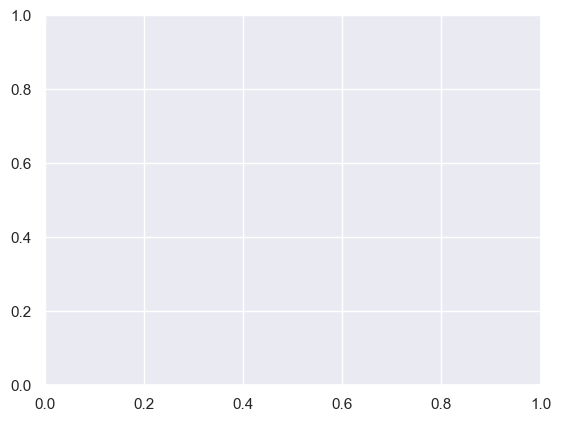

interactive(children=(SelectMultiple(description='Column(s):', index=(2,), options=('fuelconsumption_city_l_10…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [14]:
boxplot = Boxplot_ggplot()
interact(boxplot.fuel_co2_boxplot, columns=boxplot.selection_button)

### Interesting Insights

The boxplots of fuel consumption, measured in litres per 100 kilometers, above show the distribution of fuel consumption in the city, highway, or as their combination for all types of cars. The median fuel consumption in the city for all cars is around 12 litres per 100 kilometers, while the median fuel consumption on the highway for all cars is around 10 litres per 100 kilometers. The combined fuel consumption for all cars is the vehicle's city's and highway's average fuel consumption, which is around 11 litres per 100 kilometers.

Fuel consumption and $CO2$ emissions have a strong, positive relationship. The higher the fuel consumption, the higher the $CO2$ emissions. The boxplot of $CO2$ emissions, measured in grams per kilometer, above shows the distribution of $CO2$ emissions for all types of cars. The median $CO2$ emission for all cars is around 250 grams per kilometer. Moreover, this column has outliers on either side of the boxplot, implying that electric cars have zero $CO2$ emissions and fuel-only luxury sports cars have very high $CO2$ emissions.

## Scatter Plot of Electric Vehicle Ranges and Charging Time by Car Size and Model Year 

In [15]:
%%capture

%%sql --save electric_range_charge --no-execute
SELECT range1_km, recharge_time_h, vehicleclass_, model_year
FROM electric

In [16]:
%%capture

electric_range = %sql SELECT * FROM electric_range_charge

electric_range = electric_range.DataFrame()

# convert model_year to int, range and recharge to float

electric_range["model_year"] = electric_range["model_year"].astype(int)
electric_range["range1_km"] = pd.to_numeric(
    electric_range["range1_km"], errors="coerce"
)
electric_range["recharge_time_h"] = pd.to_numeric(
    electric_range["recharge_time_h"], errors="coerce"
)

# group vehicle class into sedan or SUV

electric_range["vehicle_size"] = np.where(
    electric_range["vehicleclass_"].isin(
        ["subcompact", "compact", "mid-size", "full-size", "two-seater"]
    ),
    "Sedan or smaller",
    "SUV or larger",
)

# group model year into 2012-2021 and 2022-2023

electric_range["model_year_grouped"] = np.where(
    electric_range["model_year"] <= 2021, "2012-2021", "2022-2023"
)

In [17]:
scatter = Seaborn_Scatter(electric_range)
interact(scatter.draw_scatter_electric_range, hue=scatter.dropdown)

interactive(children=(Dropdown(description='(Un)select Hue:', options=('vehicle_size', 'model_year_grouped', N…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Interesting Insights

The above scatterplot helps us compare the ranges and charging times of electric cars by their size or model year. Although one could deduce that higher recharge times (depending on the car's battery size, quality, etc.) would lead to travelling greater ranges, the graph offers more details that are worth exploring. For example, electric cars manufactured recently (2022 and onwards) have a much higher range, on average, than those manufactured between 2012 and 2021. This is likely due to the advancements in battery technology and the increased demand for electric cars. Moreover, some electric cars recently manufactured provide a better range with 10 hours of recharge time than those manufactured previously with 12 hours of recharge time. Furthermore, some new electric cars with recharge times of 10 hours provide as good a range as both new and older electric cars with recharge times greater than 10 hours (13 hours being the outlier). Maybe 10 hours is the sweet spot for recharge time?

If we shift our focus to vehicle size, there are more electric sedans (and smaller) than there are SUV's (and larger) for lower recharge times between 4 to 7 hours and this is expected due to the difference in car sizes. Sedans, on average, also seem to provide greater ranges than SUV's for recharge times greater than 7 hours. However, for recharge times less than 7 hours, SUV's provide greater ranges than sedans. This could be due to the fact that SUV's have larger batteries and, therefore, can travel greater ranges with less recharge time. Moreover, some sedans with 10 hours of recharge time provide better ranges than all SUV's do with greater than 10 hours of recharge time!

Therefore, consumers have a wide range of options to choose from when it comes to electric cars! Choosing wisely by assessing the tradeoff between recharge time and range is key and this graph helps us do just that.

## Histogram of $CO_2$ Emissions by Vehicle and Fuel Type

In [18]:
%%capture

%%sql --save hist_co2 --no-execute
SELECT vehicle_type, mapped_fuel_type, co2emissions_g_km	
FROM all_vehicles
WHERE co2emissions_g_km is not null 

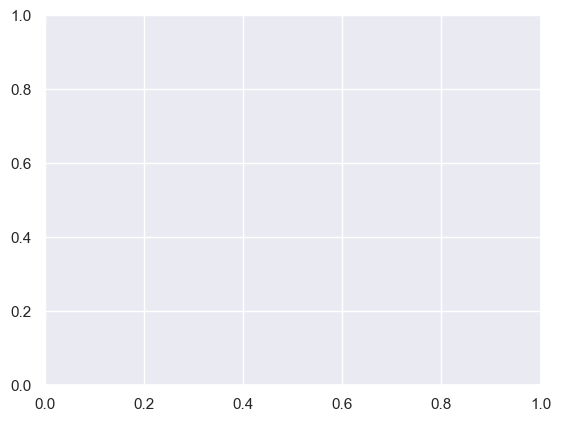

interactive(children=(IntSlider(value=10, description='Bins:', max=20, min=1), Dropdown(description='Colormap:…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [19]:
histogram = Histogram_ggplot()
interact(
    histogram.co2_histogram,
    b=histogram.intslider,
    cmap=histogram.dropdown,
    fill=histogram.radio_button,
)

### Interesting Insights

The histogram above represents the distribution of $CO_2$ emissions, measured in grams per kilometer. If we select the `fill` attribute to `vehicle_type`, we obtain a clear view that fuel-only cars emit the most $CO_2$. In fact, they can pollute up to 6x more than hybrid cars! Hybrid cars have both an electric motor and a gasoline engine, which allows them to emit less $CO_2$ than fuel-only cars. The range of $CO_2$ emitted from hybrid vehicles ranges between 10 to 80 grams per kilometer, while the distribution of $CO_2$ emissions for fuel-only cars ranges from 100 to 500 grams per kilometer, with the bulk of vehicles emitting between 200 to 300 grams per kilometer. Electric cars have zero carbon dixoide emissions and are, hence, fittingly also known as zero-emission vehicles.

Given these findings, the efforts of the Canadian government to increase the supply of electric vehicles in Canada by 2035[$^2$](https://www.canada.ca/en/environment-climate-change/news/2022/12/let-it-roll-government-of-canada-moves-to-increase-the-supply-of-electric-vehicles-for-canadians.html) will likely have a positive impact on the environment. 

Selecting the `fill` attribute to `mapped_fuel_type` and adjusting the histogram to 12 bins allows us to see that the majority of vehicles in Canada run on gasoline, premium being more harmful to the environment than regular as it is the only fuel type that emits greater than 450 grams per kilometer in some cars. However, since most cars run on regular gasoline, the area occupied for it in the histogram is greater. Diesel and Ethanol (E85) are slightly cleaner than gasoline as their emissions range from 150 to 400 grams per kilometer with the bulk of vehicles emitting between 200 to 300 grams per kilometer (similar to both gasoline types). 

## $CO_2$ Emissions of Hybrid and Fuel-Only US Car Brands by Transmission Type

In [20]:
%%capture

%%sql --save co2_usa --no-execute
SELECT vehicle_type, make_, co2emissions_g_km, transmission_type
FROM all_vehicles
WHERE co2emissions_g_km is not null AND
vehicle_type IN ('fuel-only', 'hybrid') AND
make_ IN ('cadillac', 'chevrolet', 'chrysler', 'ford', 'jeep', 'lincoln')

In [21]:
%%capture

co2_usa = %sql SELECT * FROM co2_usa
co2_usa = co2_usa.DataFrame()

# convert co2 to float

co2_usa["co2emissions_g_km"] = pd.to_numeric(co2_usa["co2emissions_g_km"])

In [22]:
boxplot = Seaborn_Boxplot(co2_usa)
interact(boxplot.draw_boxplot_usa, hue=boxplot.dropdown)

interactive(children=(Dropdown(description='(Un)select Hue:', options=('vehicle_type', 'transmission_type', No…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Interesting Insights

The boxplots above show the distribution of $CO_2$ emissions for hybrid and fuel-only US manufactured cars. Viewing the boxplot at its highest level i.e without a `hue`, suggests that Chrysler has the lowest median $CO_2$ emission, at around 250 grams per kilometer, out of all car brands. Chevrolet, on the other hand, has the highest median $CO_2$ emission, at around 300 grams per kilometer, out of all car brands. Chrysler also has also the lowest interquartile range, which could imply that the $CO_2$ emissions of its cars are more consistent than those of other car brands. 

However, upon selecting `hue` as `vehicle_type`, we see that Chevrolet's hybrid cars have the lowest median $CO_2$ emission out of all hybrid car brands. Yet, its fuel-only cars pollute the most on average. Jeep's hybrid cars pollute the most, on average, out of all US hybrid car brands, while its fuel-only cars' median $CO_2$ emissions are at par with that of Chrysler's, the cleanest fuel-only US brand.

Lastly, the boxplot of $CO_2$ emissions for hybrid and fuel-only US manufactured cars by transmission type portrays that continuously variable transmission cars pollute the least out of the other available transmissions. These cars would likely correspond to the hybrid cars of the US brands, which are the cleanest out of all hybrid cars. Another interesting observation is that all brands, apart from Chrysler, have lower median $CO_2$ emissions for manual transmission cars than for automatic transmission cars. In fact, the Environmental Protection Agency (EPA) found that vehicles with a manual transmission were more efficient than their automatic counterparts through about 2010, but modern automatic transmissions are now more efficient [$^3$](https://www.epa.gov/sites/default/files/2021-01/documents/420r21003.pdf). Only Ford has an automated manual transmission available for its cars, which has a significantly wide distribution for $CO_2$ emissions, similar to Cadillac's continuously variable transmissions cars, but a median $CO_2$ emission that is lower than that of its automatic transmission cars.

## References

${^1}{^,}{^2}$ Canada, Service. “Government of Canada.” Service Canada, n.d. https://www.canada.ca/. 

$^3$ The 2020 EPA Automotive Trends Report: Greenhouse gas emissions, fuel ..., n.d. https://www.epa.gov/sites/default/files/2021-01/documents/420r21003.pdf. 